### **DCGAN with MNIST Dataset**

**Imports**

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

**Utilities**

In [2]:
def plot_results(images, n_cols=None):
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

**Download and Prepare the Dataset**

In [3]:
(X_train, _), _ = keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype(np.float32) / 255

X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

4422102/4422102 [==============================] - 0s 0us/step


**Build the Model**

**Generator**

In [4]:
codings_size = 32

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

shape of the generated batch: (16, 28, 28, 1)


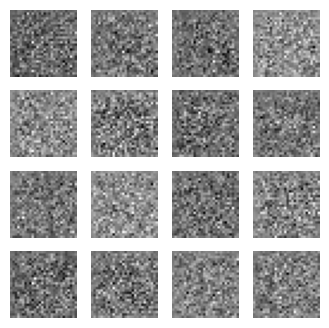

In [5]:
test_noise = tf.random.normal([16, codings_size])

test_image = generator(test_noise)

plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

**Discriminator**

In [6]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [7]:
gan = keras.models.Sequential([generator, discriminator])

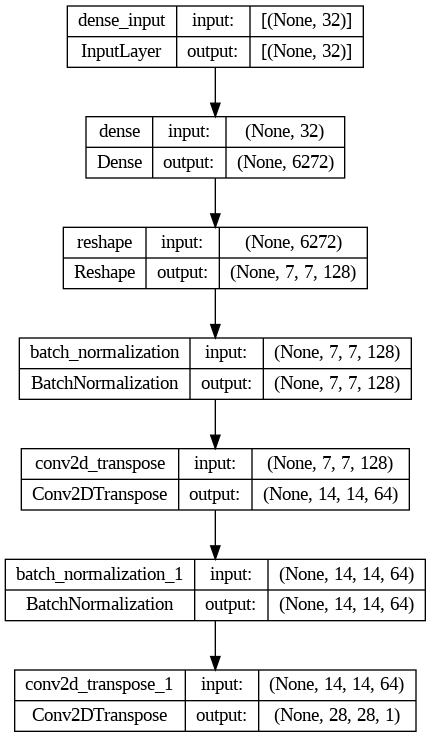

In [19]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

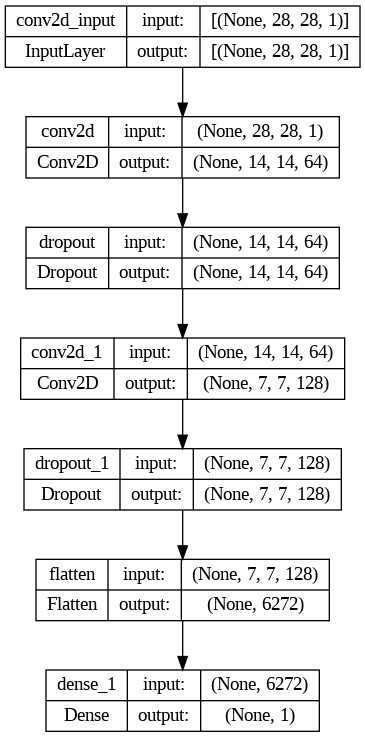

In [20]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

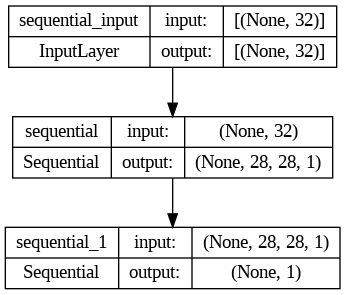

In [21]:
tf.keras.utils.plot_model(gan, show_shapes=True, show_layer_names=True)

**Training Model**

In [8]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [9]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            batch_size = real_images.shape[0]

            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            fake_images = generator(noise)

            mixed_images = tf.concat([fake_images, real_images], axis=0)

            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            discriminator.trainable = True

            discriminator.train_on_batch(mixed_images, discriminator_labels)


            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            generator_labels = tf.constant([[1.]] * batch_size)

            discriminator.trainable = False

            gan.train_on_batch(noise, generator_labels)

        plot_results(fake_images, 16)
        plt.show()

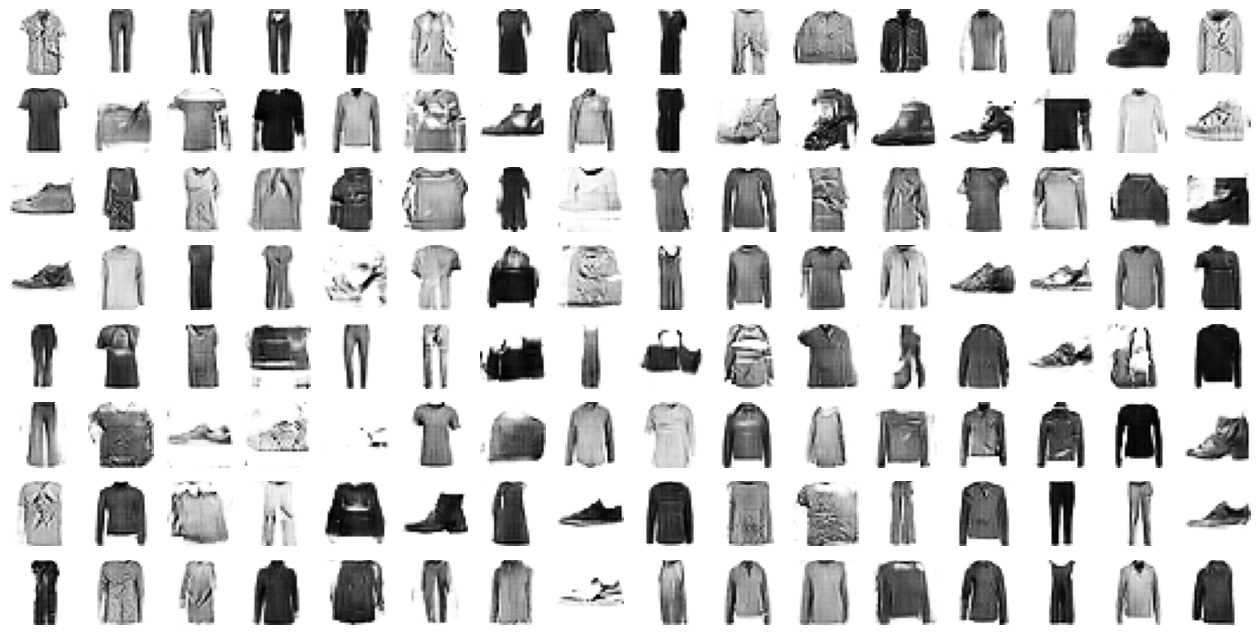

In [10]:
train_gan(gan, dataset, codings_size, 100)